# days를 집어넣는 모델

예를 들면 이런 것이죠. train 데이터가 0 ~ 1026인가 아무튼 그렇게 순차적으로 되어 있는데, 이걸 0~6로 바꾸는 겁니다. 7일치의 데이터 단위로 짜르는 것이죠. 그리고 다음 날을 예측하는 모델로 학습시킵니다.

test 데이터는 이미 0~6일 단위의 데이터로 되어 있죠. pred 시킵니다. 그리고 6일치가 예측한 7일과 8일만 뽑아서 서브미션으로 내는 것이죠.

똥망입니다~~~

In [1]:
import load_dtypes as ld
import warnings
warnings.filterwarnings(action='ignore')
import os, sys

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold

In [2]:
TRAIN_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv'
TEST_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\test'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\sample_submission.csv'

In [17]:
train = ld.load_dtypes(TRAIN_PATH)
train.info()
submission = pd.read_csv(SUBMISSION_PATH)

C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int16  
 1   Hour    52560 non-null  int8   
 2   Minute  52560 non-null  int8   
 3   DHI     52560 non-null  int16  
 4   DNI     52560 non-null  int16  
 5   WS      52560 non-null  float32
 6   RH      52560 non-null  float32
 7   T       52560 non-null  int8   
 8   TARGET  52560 non-null  float32
dtypes: float32(3), int16(3), int8(3)
memory usage: 1.1 MB


In [18]:
# hour와 minute을 합쳐주는 함수입니다.
def sum_hour_minute(train):
    # 0과 30으로 되어 있는 minute을 0과 0.5로 바꿉니다.
    train.Minute = round(train.Minute * 0.017, 1)
    # hour에 minute을 더해줍니다.
    train.Hour = train.Hour + train.Minute
    
    return train

In [19]:
train = sum_hour_minute(train)
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0.0,0.0,0,0,1.5,69.080002,-12,0.0
1,0,0.5,0.5,0,0,1.5,69.059998,-12,0.0
2,0,1.0,0.0,0,0,1.6,71.779999,-12,0.0
3,0,1.5,0.5,0,0,1.6,71.750000,-12,0.0
4,0,2.0,0.0,0,0,1.6,75.199997,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21.5,0.5,0,0,2.4,70.699997,-4,0.0
52556,1094,22.0,0.0,0,0,2.4,66.790001,-4,0.0
52557,1094,22.5,0.5,0,0,2.2,66.779999,-4,0.0
52558,1094,23.0,0.0,0,0,2.1,67.720001,-4,0.0


In [20]:
new_days = []
for i in range(7):
    for k in range(48):
        new_days.append(i)
        
len(new_days)

336

In [13]:
new_train = train[:52416]

In [18]:
new_train['new_days'] = new_days*156

In [20]:
new_train.drop(['Day', 'Minute'], axis=1, inplace=True)

In [21]:
new_train['TARGET_1'] = new_train.TARGET.shift(-48)
new_train['TARGET_2'] = new_train.TARGET_1.shift(-48)

In [22]:
new_train.dropna(inplace=True)
new_train.shape

(52320, 10)

In [23]:
X = new_train[:33600]
val = new_train[33600:]

In [24]:
def make_train_test_val(X, val, features):

    x_train = X[features]
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val[features]
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    print(x_train.shape)
    
    return x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2

In [25]:
x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2 = make_train_test_val(X, val, X.columns[:-2])

(33600, 8)


In [26]:
class HiddenPrints: # print를 막아주는 클래스 입니다.
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
with HiddenPrints():
    df_test = []

    for i in range(81):
        file_path = TEST_PATH + '/' + str(i) + '.csv'
        temp = pd.read_csv(file_path)
        temp = sum_hour_minute(temp)
        df_test.append(temp)

    X_test = pd.concat(df_test)
print(X_test.shape)

(27216, 9)


In [28]:
X_test.drop('Minute', axis=1, inplace=True)
X_test

,Day,Hour,DHI,DNI,WS,RH,T,TARGET
0,0,0.0,0,0,2.7,34.42,0.0,0.0
1,0,0.5,0,0,2.7,34.17,0.1,0.0
2,0,1.0,0,0,2.7,34.23,0.2,0.0
3,0,1.5,0,0,2.7,33.99,0.3,0.0
4,0,2.0,0,0,2.8,33.97,0.4,0.0
...,...,...,...,...,...,...,...,...
331,6,21.5,0,0,0.8,63.35,13.7,0.0
332,6,22.0,0,0,0.7,64.82,13.1,0.0
333,6,22.5,0,0,0.7,66.10,12.8,0.0
334,6,23.0,0,0,0.6,67.64,12.4,0.0


In [53]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', # quantile로 받아줘야 quatile regression이 가능합니다.
                          alpha=q, # 이건 나중에 quantile 받을 인자입니다.
                          n_estimators=10000, # 10000만번을 돌리겠다고? 미쳤어?
                          bagging_fraction=0.7,
                          learning_rate=0.027,
                          subsample=0.7)                   
                         
                         
    model.fit(X_train,
              Y_train,
              eval_metric = ['quantile'],
              eval_set=[(X_valid, Y_valid)],
              early_stopping_rounds=300, verbose=500) # 대신 얼리 스토핑을 넣었네요.

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles: # 9번 반복할 겁니다. quantile 마다.
        print(q)
        pred , model = LGBM(q, # 퀀틸 박아줍니다.
                            X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model) # 모델을 어펜드 해줍니다.
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1) #pred를 컨캣해줍니다.

    LGBM_actual_pred.columns=quantiles # 컬럼은 퀀틸로 박아줍니다.
    
    return LGBM_models, LGBM_actual_pred

In [30]:
# Target1
models_1, results_1 = train_data(x_train, y_train_1, x_val, y_val_1, X_test)

# Target2
models_2, results_2 = train_data(x_train, y_train_2, x_val, y_val_2, X_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[105]	valid_0's quantile: 1.38011
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[169]	valid_0's quantile: 2.22319
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.63941
Early stopping, best iteration is:
[220]	valid_0's quantile: 2.62505
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2

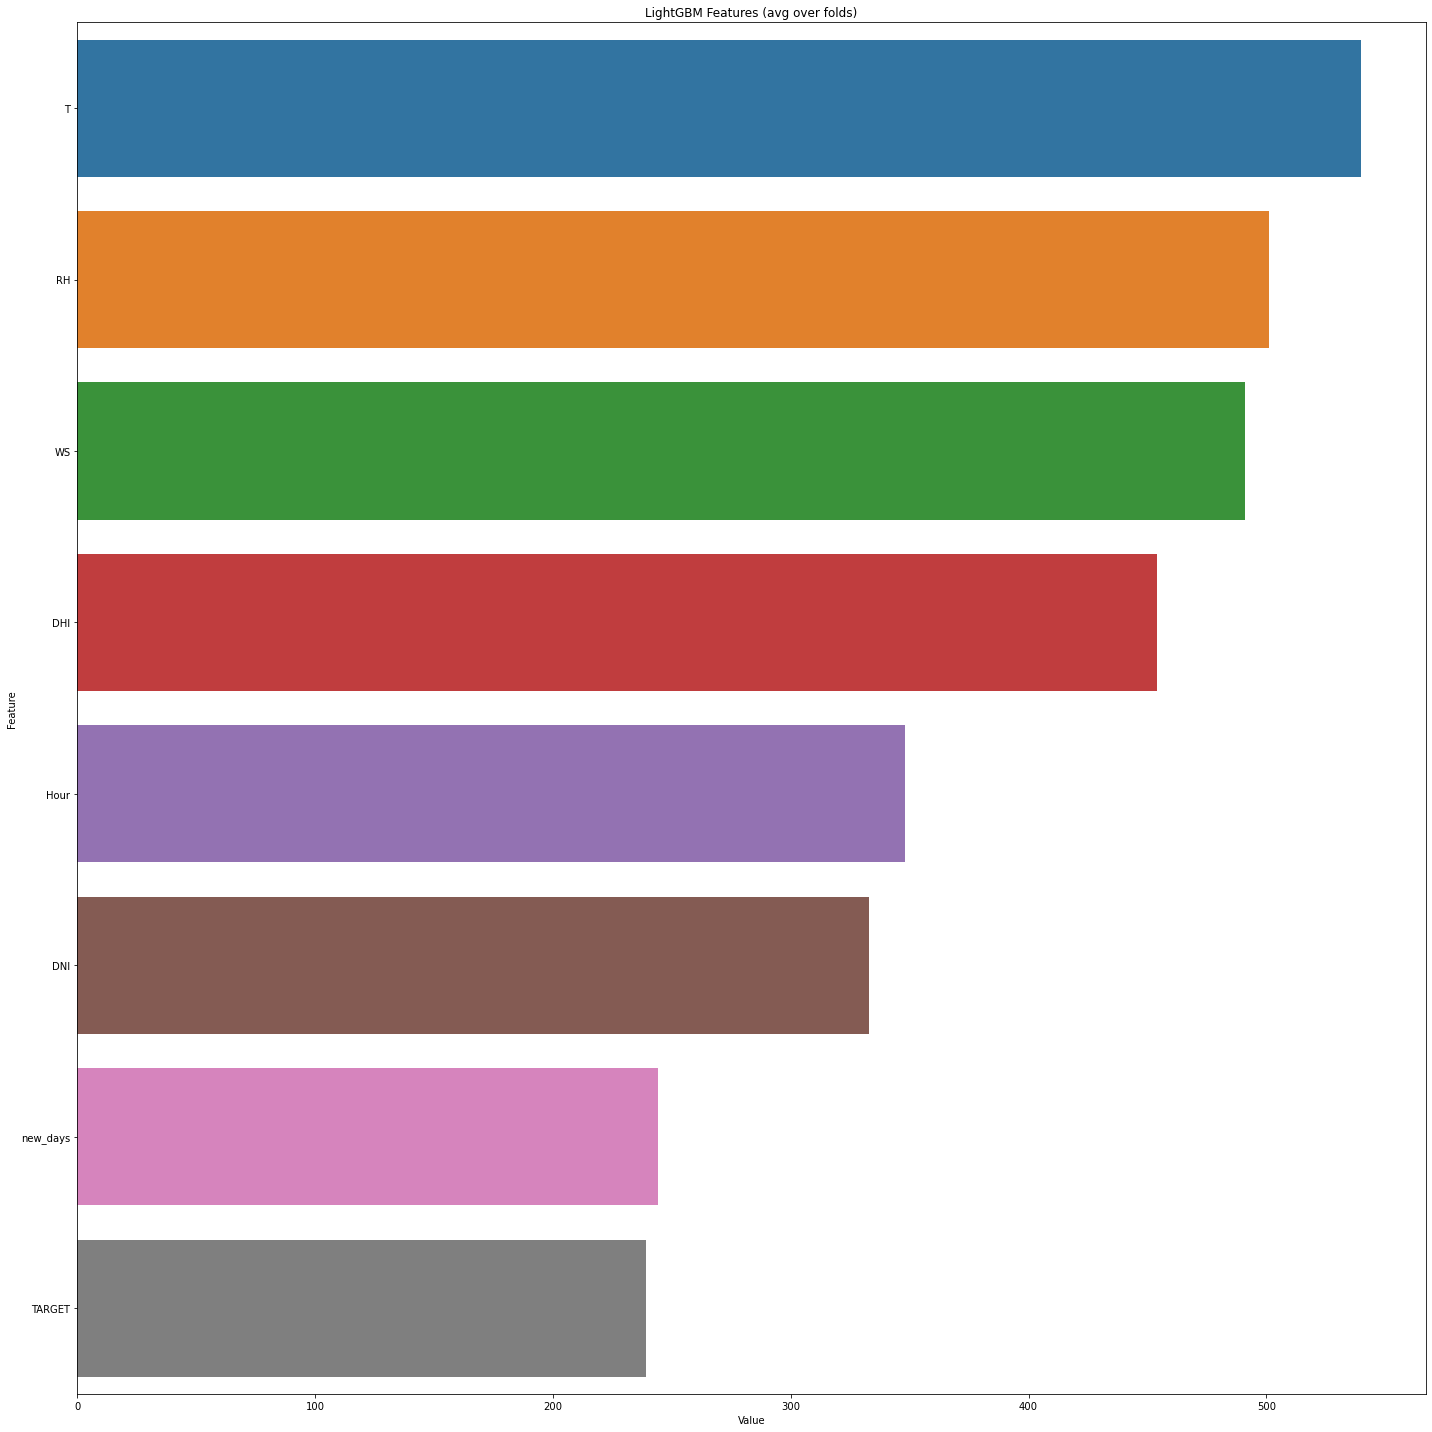

<Figure size 432x288 with 0 Axes>

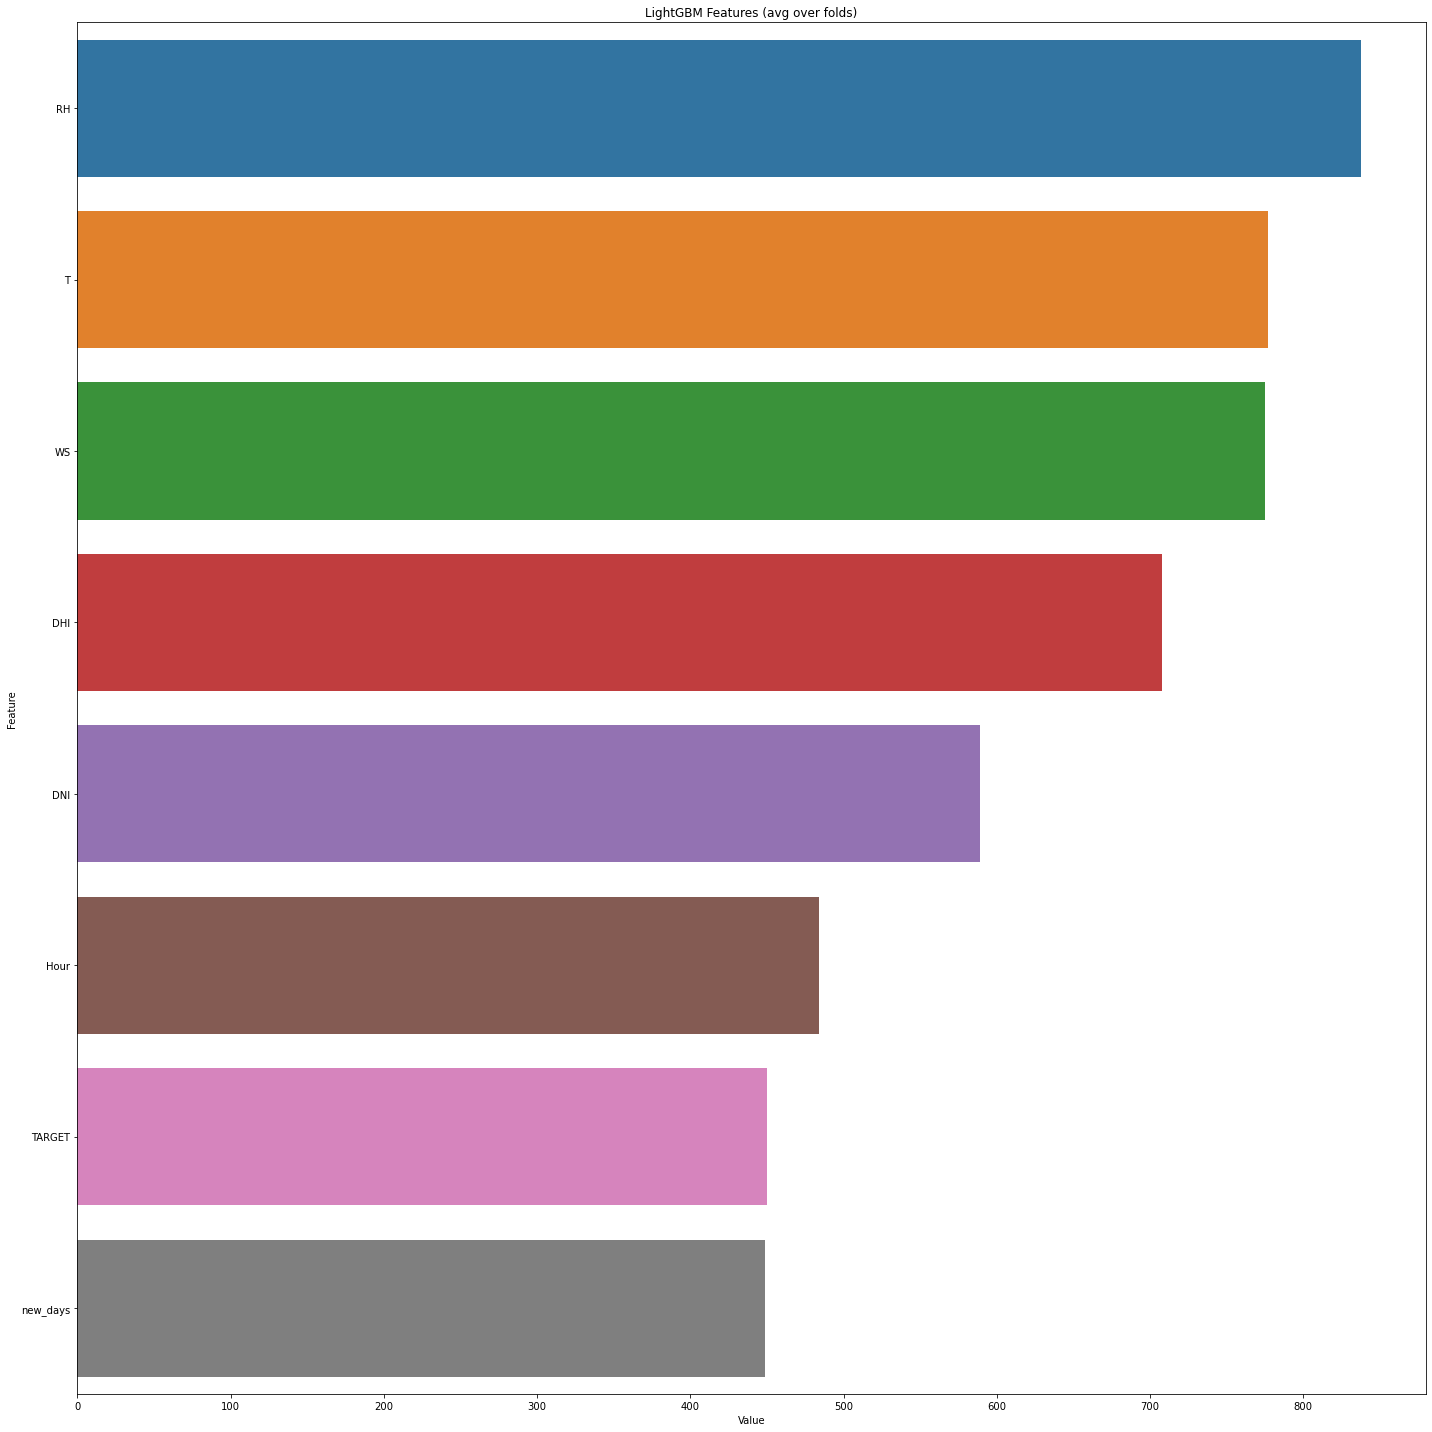

<Figure size 432x288 with 0 Axes>

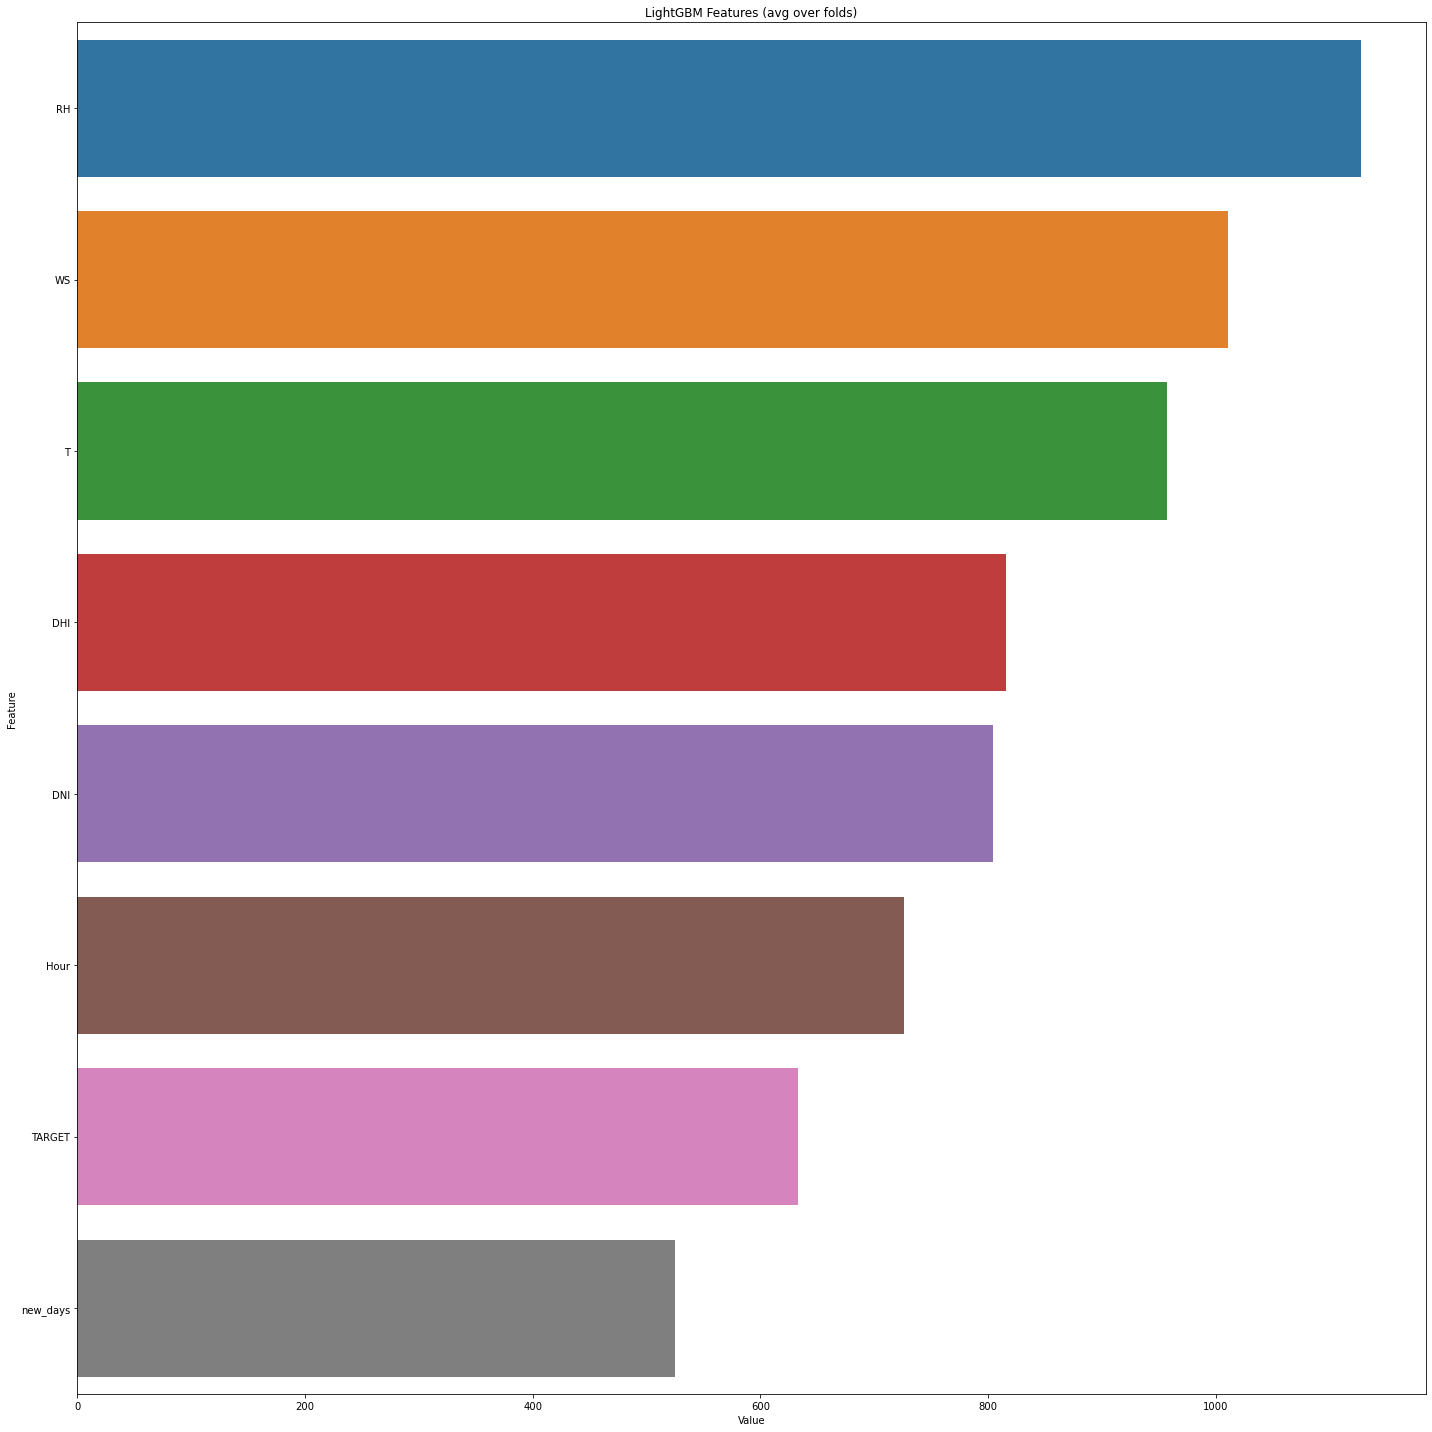

<Figure size 432x288 with 0 Axes>

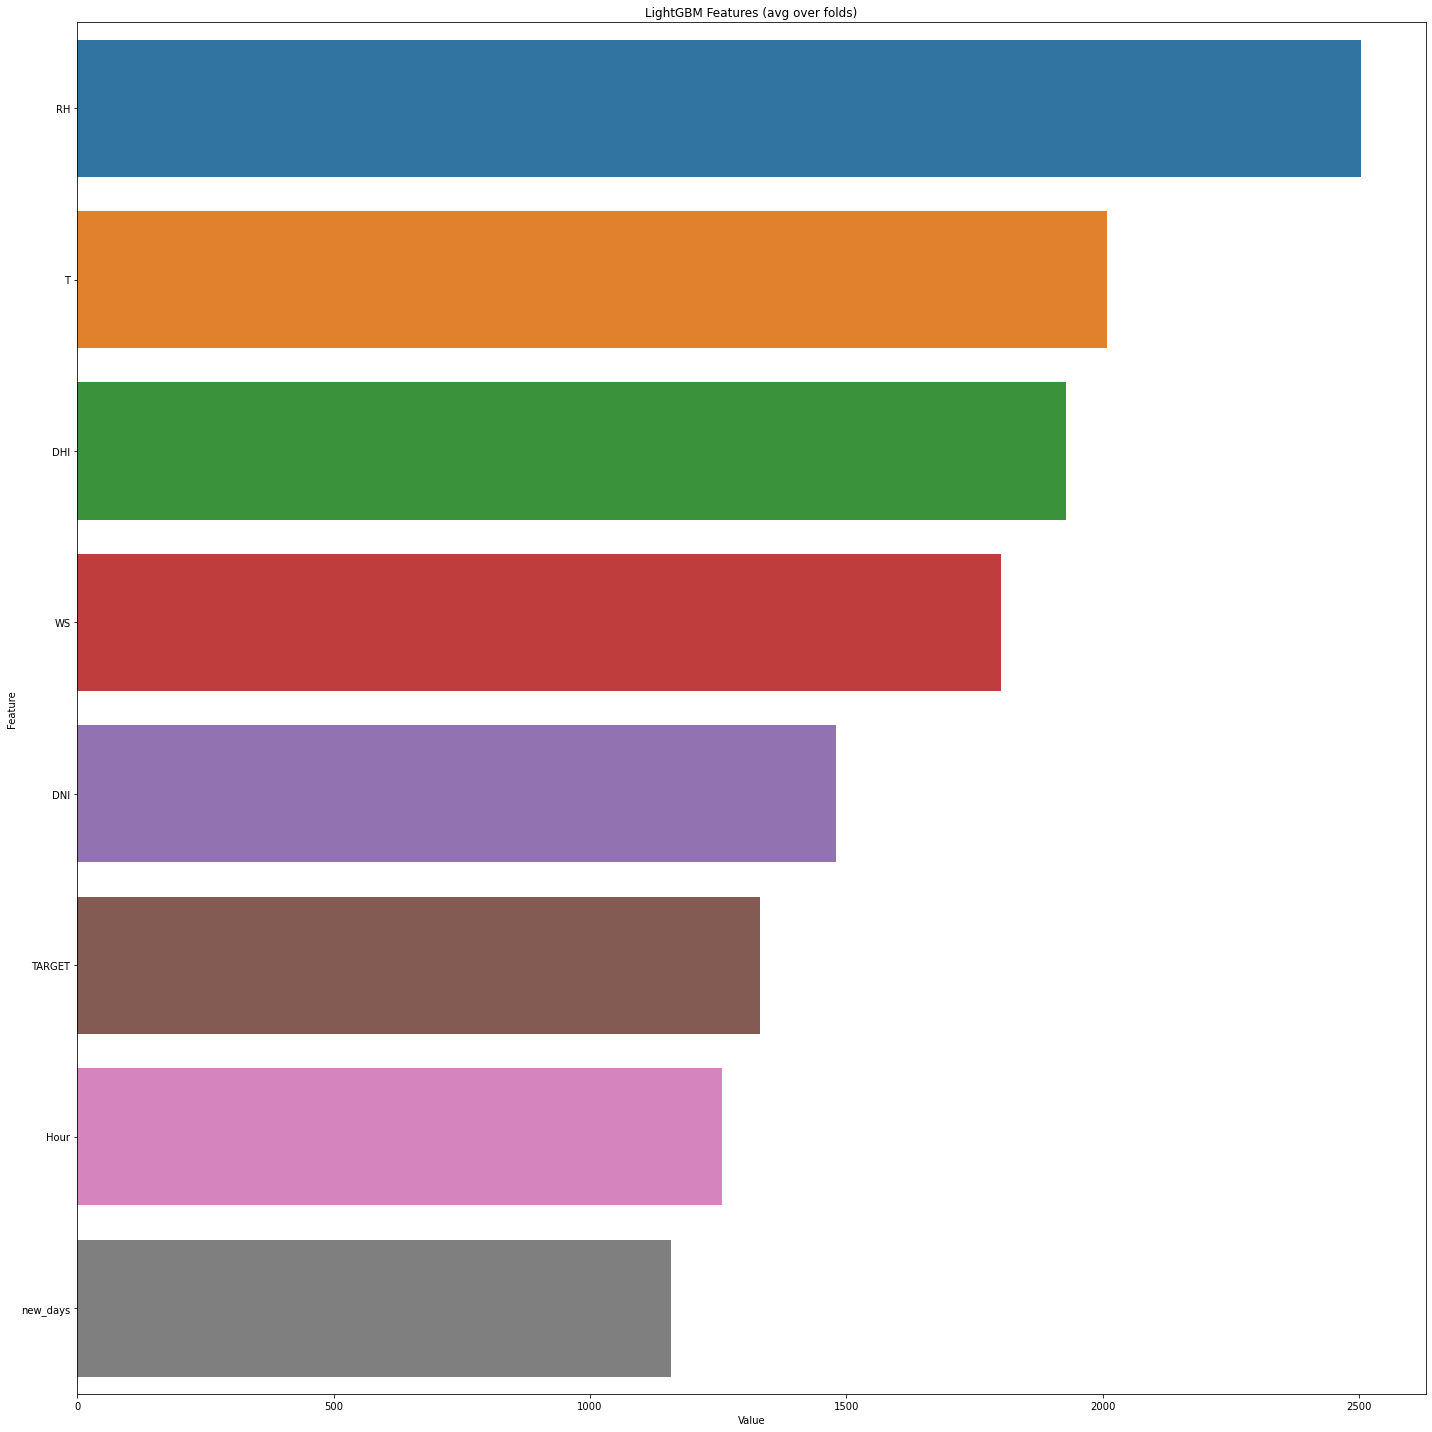

<Figure size 432x288 with 0 Axes>

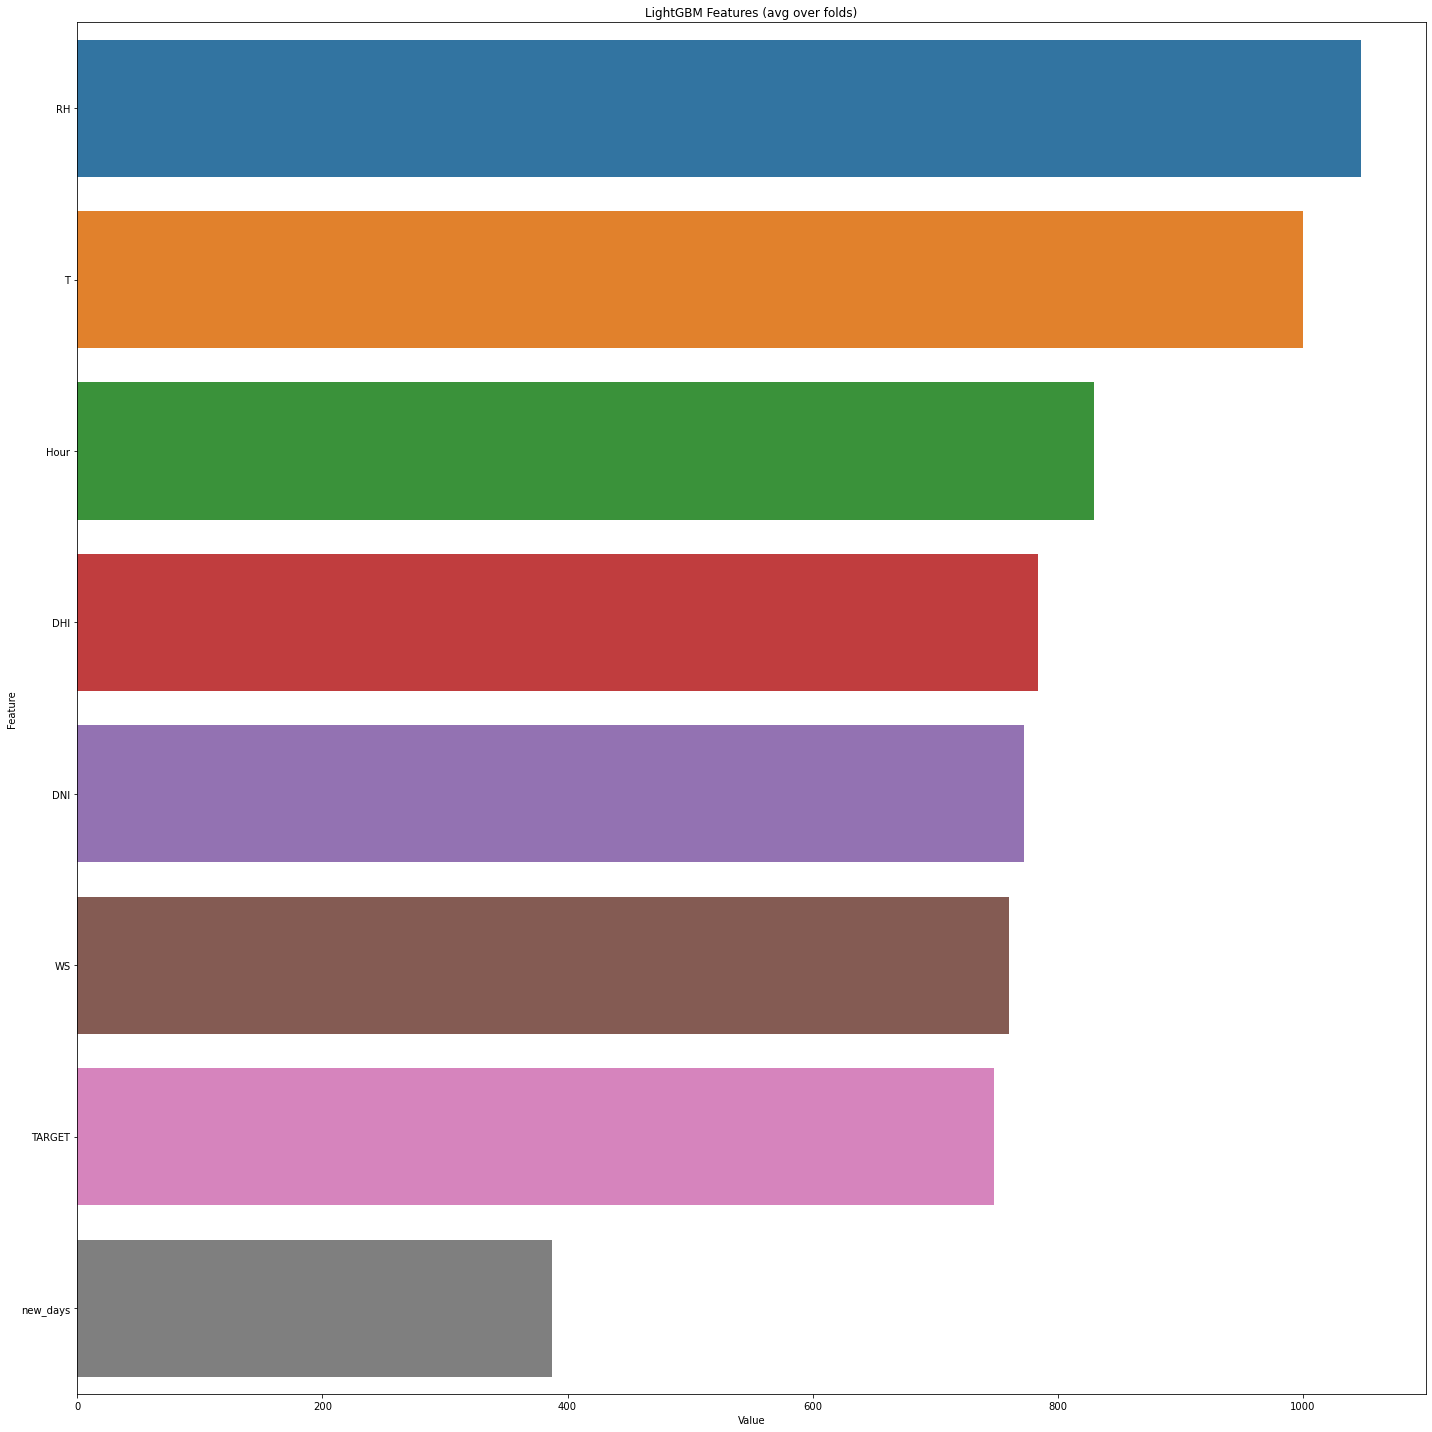

<Figure size 432x288 with 0 Axes>

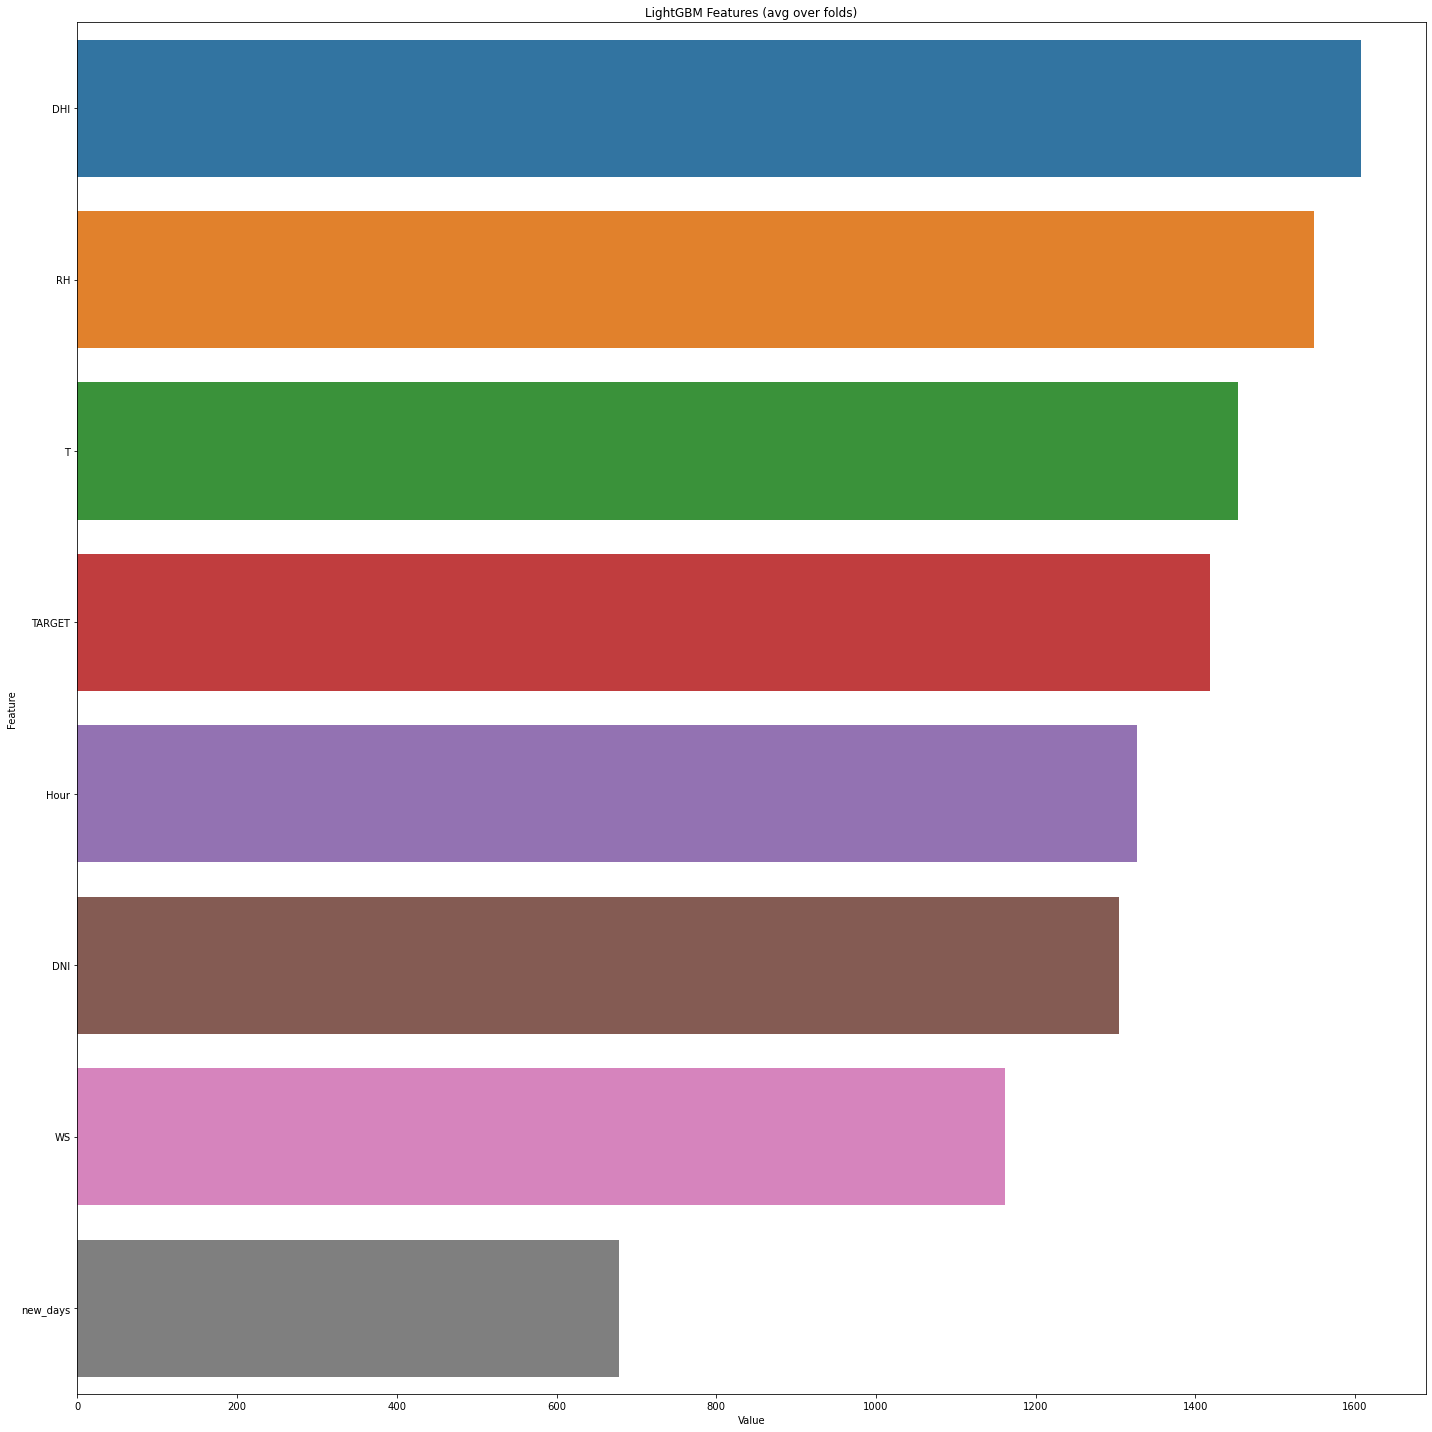

<Figure size 432x288 with 0 Axes>

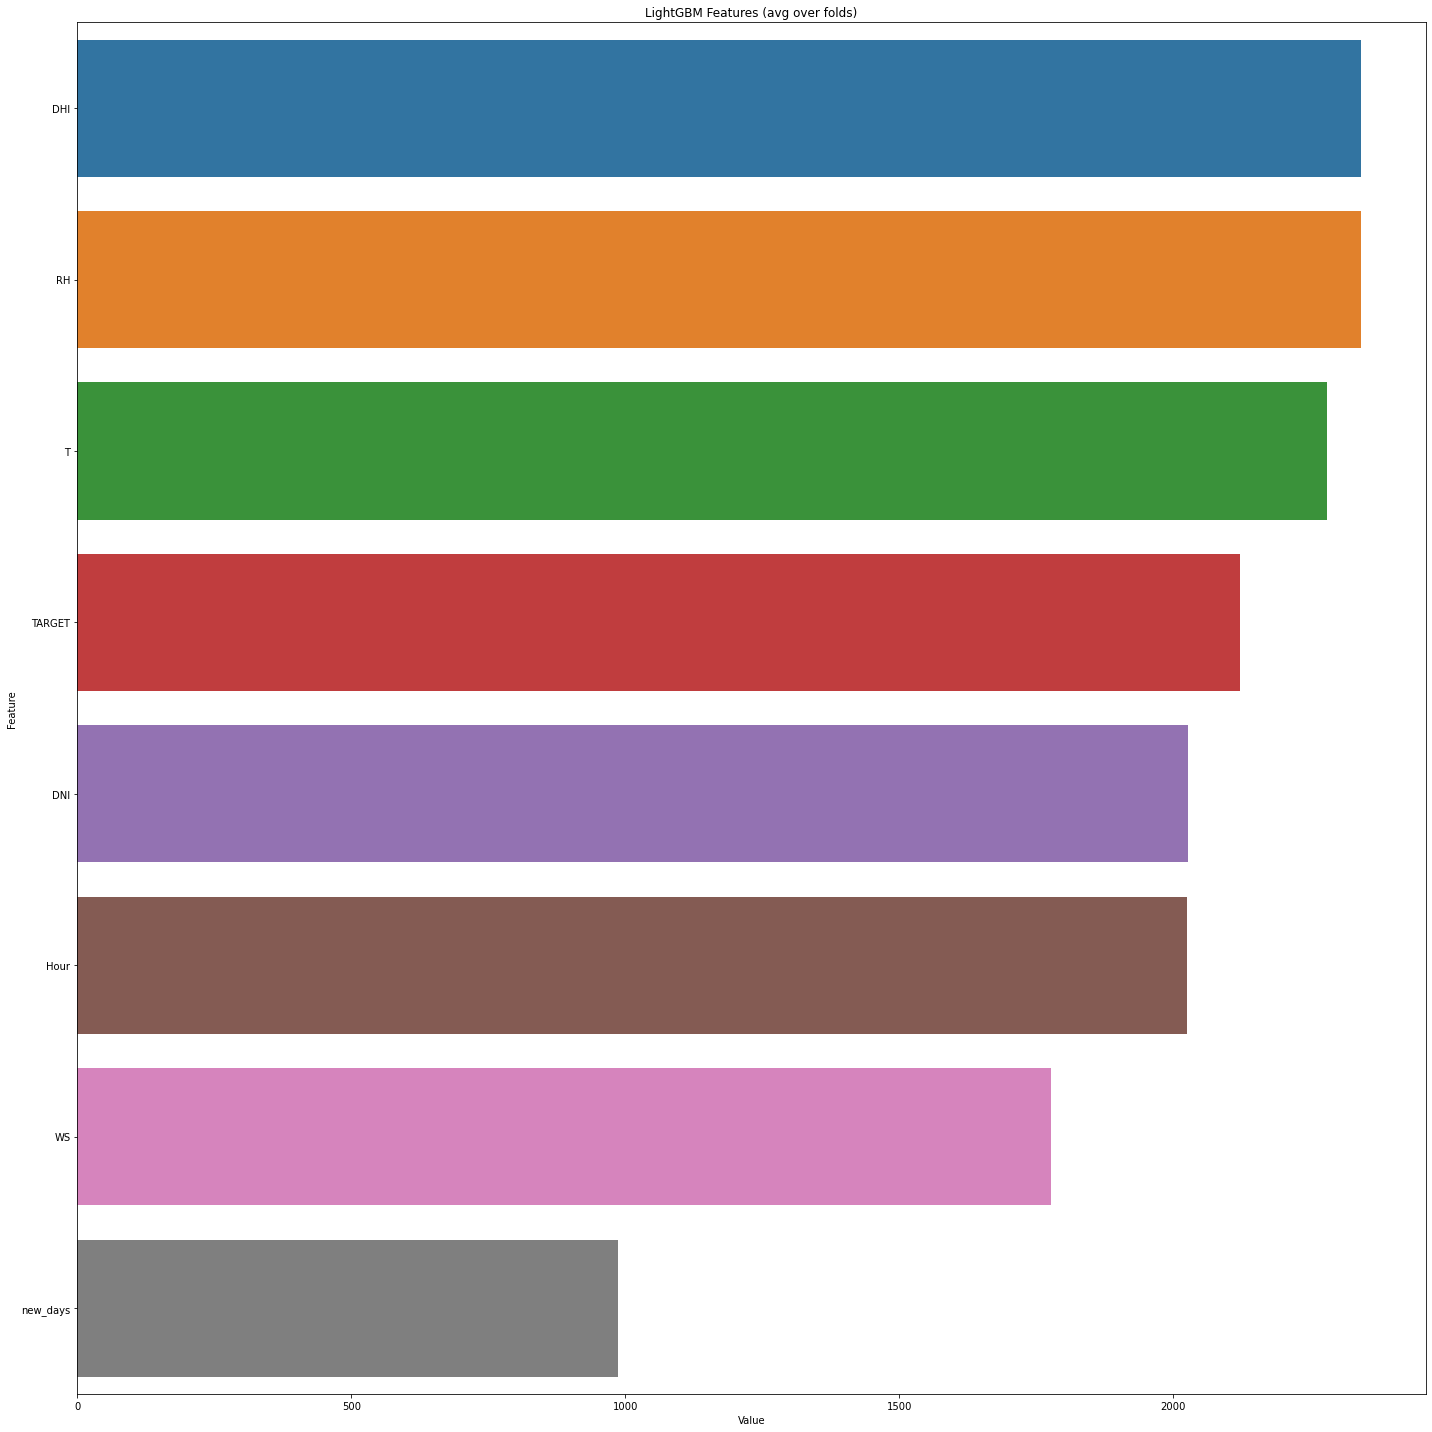

<Figure size 432x288 with 0 Axes>

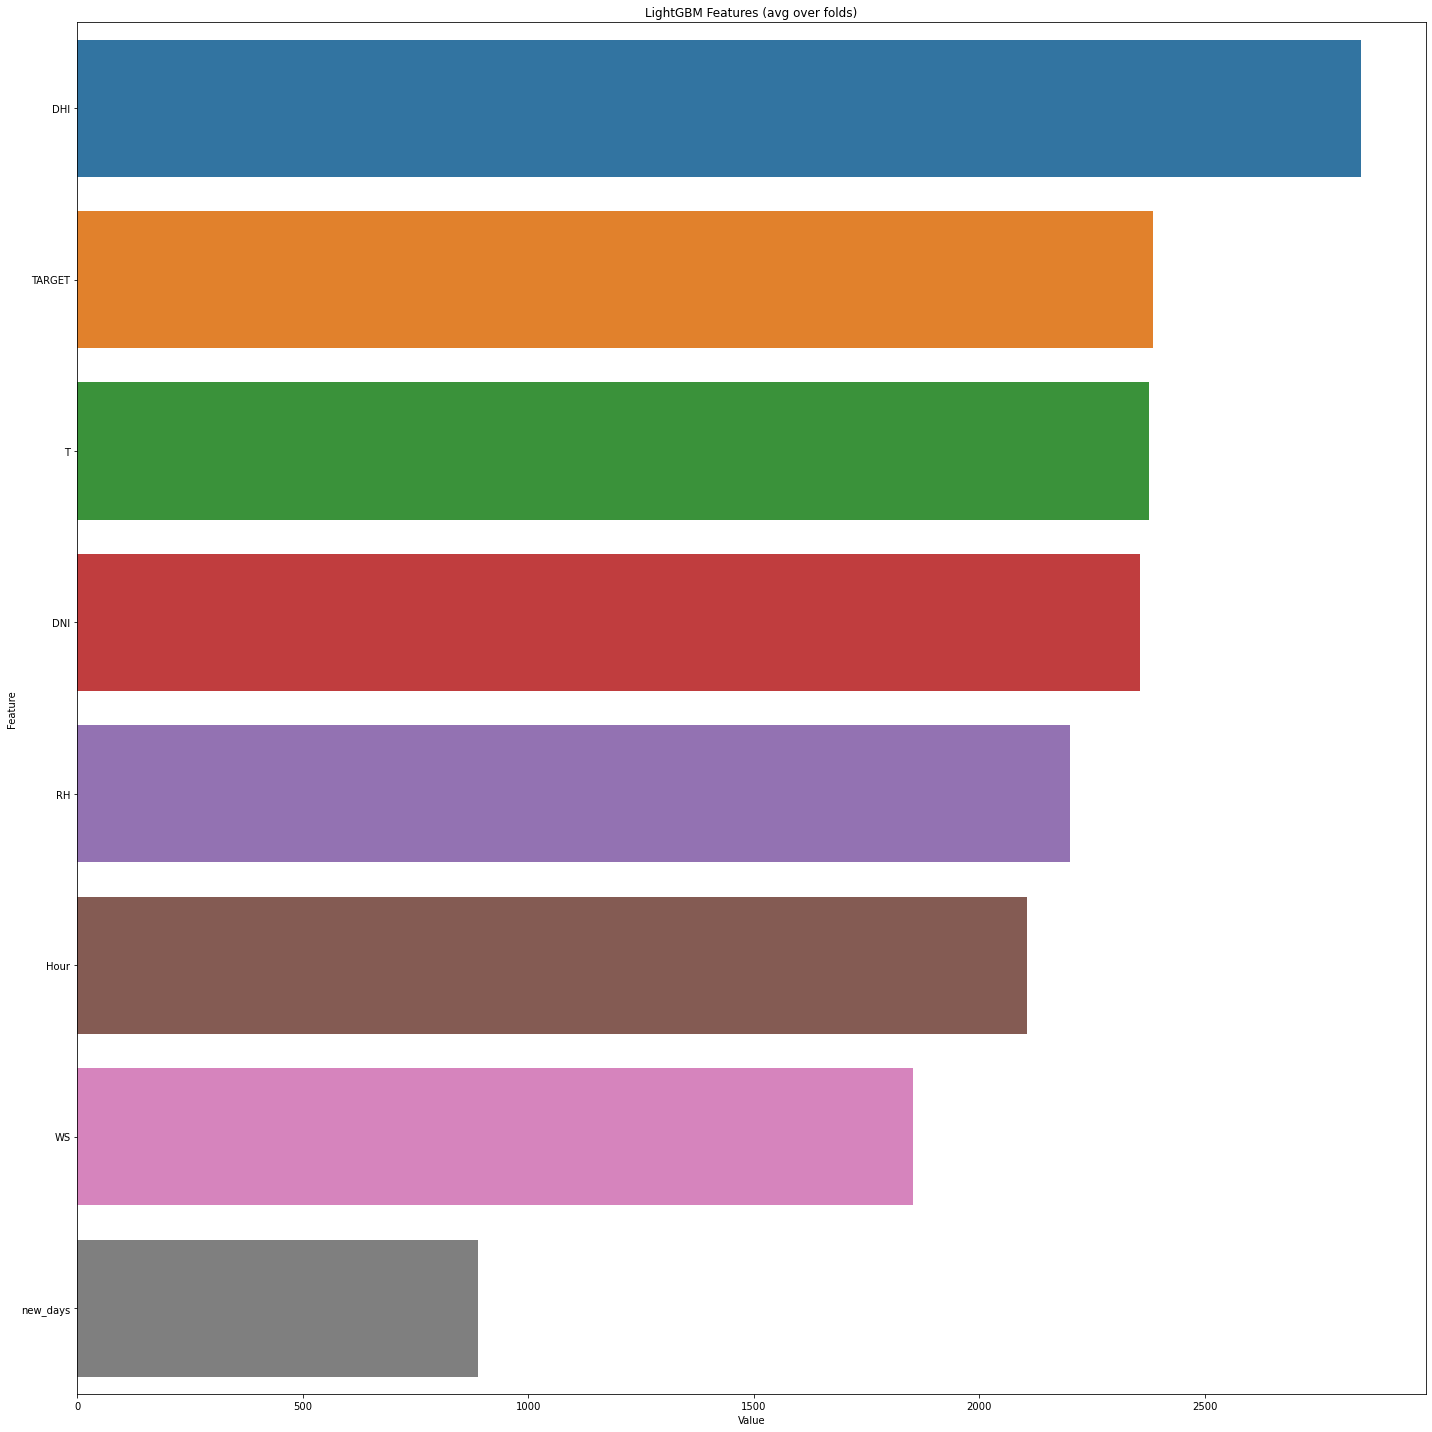

<Figure size 432x288 with 0 Axes>

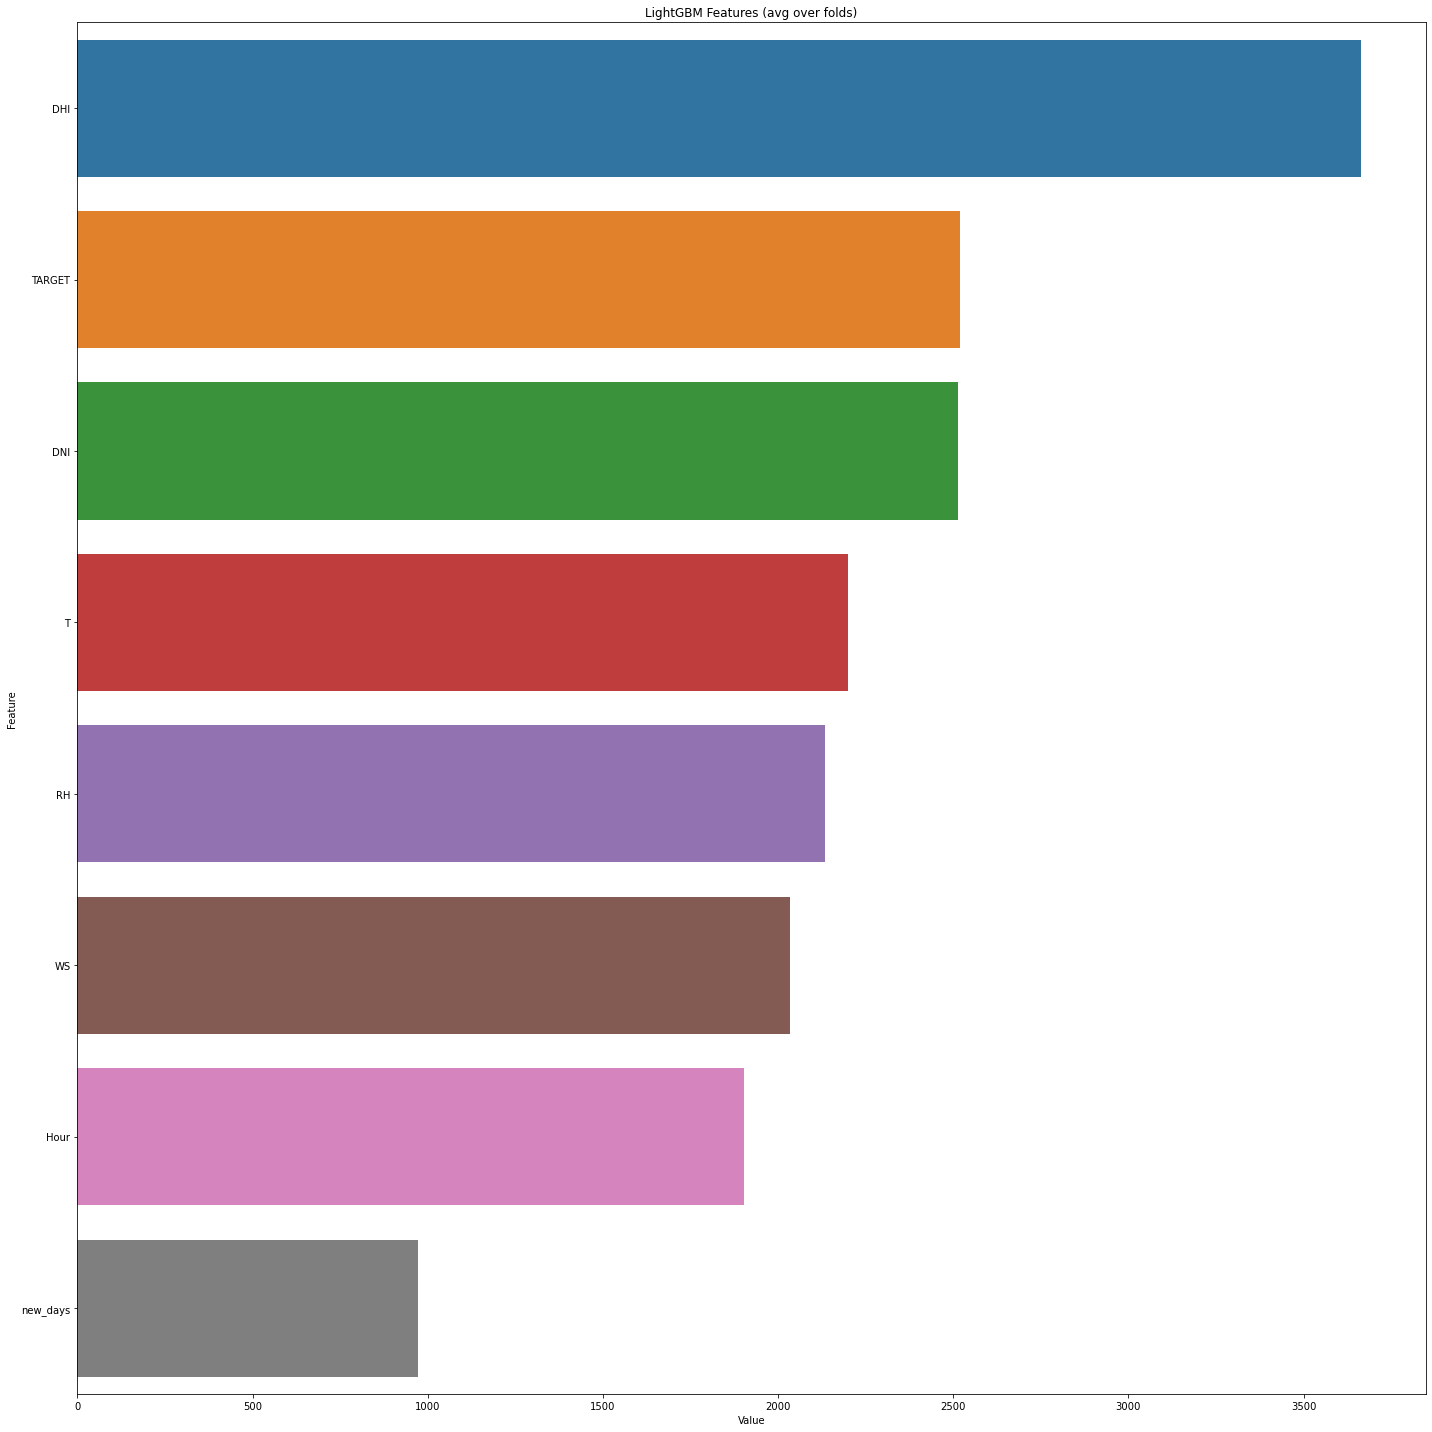

<Figure size 432x288 with 0 Axes>

In [31]:
for i in range(len(models_1)):
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(models_1[i].feature_importances_,x_train.columns)),
                               columns=['Value','Feature'])

    plt.figure(figsize=(20, 20))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    plt.savefig('lgbm_importances-01.png')

In [44]:
result_df = []

for i in range(81):
    #print(i)
    temp = results_1.iloc[336*i:336*(i+1)]
    temp = temp[-48:]
    result_df.append(temp)

final_result_1 = pd.concat(result_df)
final_result_1

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
288,0.00,0.00,0.00,0.00,0.00,0.00,0.98,23.45,36.00
289,1.38,1.70,3.29,12.75,16.31,15.68,12.75,31.24,39.29
290,1.38,1.70,3.29,12.75,16.31,15.68,12.75,31.24,39.29
291,1.38,1.70,3.29,12.75,16.31,15.68,12.75,31.24,39.29
292,1.38,1.70,3.29,12.75,16.31,15.68,12.75,31.24,39.29
...,...,...,...,...,...,...,...,...,...
27211,6.89,15.04,20.64,29.75,32.37,15.83,26.51,46.18,54.71
27212,6.94,14.83,20.58,29.67,31.36,16.62,26.93,46.27,53.74
27213,6.94,14.83,20.58,29.81,31.36,16.62,26.93,46.27,53.73
27214,6.94,14.98,20.77,29.81,31.36,18.13,27.96,46.23,53.67


In [46]:
result_df2 = []

for i in range(81):
    #print(i)
    temp = results_2.iloc[336*i:336*(i+1)]
    temp = temp[-48:]
    result_df2.append(temp)

final_result_2 = pd.concat(result_df2)
final_result_2

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
288,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.56,16.00
289,2.93,0.56,6.87,11.67,9.56,16.74,15.38,17.64,22.52
290,2.93,0.56,6.87,11.67,9.56,16.74,15.38,17.64,22.52
291,2.93,0.56,6.87,11.67,9.56,16.74,15.38,17.64,22.52
292,2.93,0.56,6.87,11.67,9.56,16.74,15.38,17.64,22.52
...,...,...,...,...,...,...,...,...,...
27211,7.95,10.50,22.59,22.79,26.73,23.87,25.15,29.58,32.49
27212,8.15,10.93,22.66,22.85,26.44,20.56,24.10,28.44,32.37
27213,8.15,10.93,22.66,22.85,26.44,20.56,24.10,28.44,31.19
27214,8.11,11.29,23.12,23.49,27.41,20.07,23.74,28.29,31.56


In [48]:
# lag model 3 window decross model

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = final_result_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = final_result_2.sort_index().values
submission[16:33]

#submission.to_csv('./submission/submission_210106-1_6days_notminute.csv', index=False)

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
16,0.csv_Day7_8h00m,1.29,2.04,1.58,10.83,13.44,6.70,4.38,22.11,18.49
17,0.csv_Day7_8h30m,1.26,0.96,0.42,9.87,13.59,5.72,1.73,18.63,16.65
18,0.csv_Day7_9h00m,1.27,2.14,1.13,13.67,13.82,4.81,2.22,18.65,15.16
19,0.csv_Day7_9h30m,0.82,4.03,1.26,13.60,13.20,4.27,1.02,18.98,14.88
20,0.csv_Day7_10h00m,0.82,4.82,2.12,14.10,13.20,7.20,2.62,18.94,13.98
21,0.csv_Day7_10h30m,0.82,4.49,2.30,14.15,13.21,7.20,2.62,18.94,13.98
22,0.csv_Day7_11h00m,1.14,4.83,2.38,14.12,13.21,7.20,2.62,18.94,13.98
23,0.csv_Day7_11h30m,1.14,4.85,2.39,14.09,13.20,7.17,2.62,18.90,13.98
24,0.csv_Day7_12h00m,1.51,5.03,3.12,14.20,13.20,7.17,2.62,18.93,13.98
25,0.csv_Day7_12h30m,1.51,5.03,3.31,14.23,13.21,7.20,2.62,18.93,13.98


# 새로운 아이디어가 필요합니다.

In [29]:
train = ld.load_dtypes(TRAIN_PATH)
train.info()
submission = pd.read_csv(SUBMISSION_PATH)

C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int16  
 1   Hour    52560 non-null  int8   
 2   Minute  52560 non-null  int8   
 3   DHI     52560 non-null  int16  
 4   DNI     52560 non-null  int16  
 5   WS      52560 non-null  float32
 6   RH      52560 non-null  float32
 7   T       52560 non-null  int8   
 8   TARGET  52560 non-null  float32
dtypes: float32(3), int16(3), int8(3)
memory usage: 1.1 MB


In [30]:
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.080002,-12,0.0
1,0,0,30,0,0,1.5,69.059998,-12,0.0
2,0,1,0,0,0,1.6,71.779999,-12,0.0
3,0,1,30,0,0,1.6,71.750000,-12,0.0
4,0,2,0,0,0,1.6,75.199997,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.699997,-4,0.0
52556,1094,22,0,0,0,2.4,66.790001,-4,0.0
52557,1094,22,30,0,0,2.2,66.779999,-4,0.0
52558,1094,23,0,0,0,2.1,67.720001,-4,0.0


타겟이 없이 가면 어떨까?

In [31]:
train['TARGET_1'] = train.TARGET.shift(-48)
train['TARGET_2'] = train.TARGET_1.shift(-48)

In [32]:
train.drop(['Day', 'Minute', 'TARGET'], axis=1, inplace=True)

In [36]:
shifted_columns = train.columns[1:-2]
lags = [48, 96, 144, 192, 240] # 뒤에서부터 하나씩 줄인다.

In [37]:
def shift_columns(data, shifted_columns, lags):
    
    temp = data.copy()
    for lag in lags:
        for col in shifted_columns:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag)
            
    return temp

In [38]:
train = shift_columns(train, shifted_columns, lags)
train.shape

(52560, 33)

In [39]:
train.dropna(inplace=True)
train.shape

(52224, 33)

In [40]:
train

,Hour,DHI,DNI,WS,RH,T,TARGET_1,TARGET_2,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,DHI_lag_96,DNI_lag_96,WS_lag_96,RH_lag_96,T_lag_96,DHI_lag_144,DNI_lag_144,WS_lag_144,RH_lag_144,T_lag_144,DHI_lag_192,DNI_lag_192,WS_lag_192,RH_lag_192,T_lag_192,DHI_lag_240,DNI_lag_240,WS_lag_240,RH_lag_240,T_lag_240
240,0,0,0,1.5,77.410004,1,0.0,0.0,0.0,0.0,2.1,72.099998,-5.0,0.0,0.0,1.8,77.760002,-14.0,0.0,0.0,2.2,73.800003,-8.0,0.0,0.0,1.6,90.660004,-10.0,0.0,0.0,1.5,69.080002,-12.0
241,0,0,0,1.7,77.419998,1,0.0,0.0,0.0,0.0,2.0,72.099998,-5.0,0.0,0.0,2.0,77.769997,-13.0,0.0,0.0,2.1,68.199997,-8.0,0.0,0.0,1.6,90.680000,-10.0,0.0,0.0,1.5,69.059998,-12.0
242,1,0,0,1.9,76.769997,1,0.0,0.0,0.0,0.0,2.0,72.139999,-5.0,0.0,0.0,2.2,77.690002,-13.0,0.0,0.0,2.1,69.059998,-8.0,0.0,0.0,1.6,88.110001,-11.0,0.0,0.0,1.6,71.779999,-12.0
243,1,0,0,2.0,76.769997,1,0.0,0.0,0.0,0.0,2.0,72.110001,-5.0,0.0,0.0,2.2,71.570000,-13.0,0.0,0.0,2.1,69.040001,-8.0,0.0,0.0,1.6,88.110001,-11.0,0.0,0.0,1.6,71.750000,-12.0
244,2,0,0,2.2,76.389999,1,0.0,0.0,0.0,0.0,2.0,72.940002,-5.0,0.0,0.0,2.2,72.620003,-13.0,0.0,0.0,2.2,69.379997,-8.0,0.0,0.0,1.6,90.849998,-11.0,0.0,0.0,1.6,75.199997,-12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52459,21,0,0,3.5,55.970001,-1,0.0,0.0,0.0,0.0,3.3,61.599998,-1.0,0.0,0.0,2.7,57.009998,-1.0,0.0,0.0,1.0,84.849998,-8.0,0.0,0.0,1.7,79.269997,-4.0,0.0,0.0,1.6,48.889999,-3.0
52460,22,0,0,3.9,54.230000,-2,0.0,0.0,0.0,0.0,3.3,58.410000,-1.0,0.0,0.0,2.7,56.820000,-1.0,0.0,0.0,1.2,82.260002,-8.0,0.0,0.0,1.7,76.800003,-4.0,0.0,0.0,1.5,51.959999,-3.0
52461,22,0,0,4.1,54.209999,-2,0.0,0.0,0.0,0.0,3.3,58.380001,-1.0,0.0,0.0,2.6,56.820000,-1.0,0.0,0.0,1.3,82.250000,-8.0,0.0,0.0,1.6,76.800003,-4.0,0.0,0.0,1.4,51.950001,-3.0
52462,23,0,0,4.3,56.459999,-2,0.0,0.0,0.0,0.0,3.4,55.939999,-1.0,0.0,0.0,2.6,56.900002,-1.0,0.0,0.0,1.5,81.139999,-8.0,0.0,0.0,1.6,80.500000,-5.0,0.0,0.0,1.3,56.099998,-3.0


In [41]:
X = train[:33600]
val = train[33600:]

In [24]:
def make_train_test_val(X, val, features):

    x_train = X[features]
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val[features]
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    print(x_train.shape)
    
    return x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2

In [43]:
features = ['Hour', 'DHI', 'DNI', 'WS', 'RH', 'T',
       'DHI_lag_48', 'DNI_lag_48', 'WS_lag_48', 'RH_lag_48', 'T_lag_48',
       'DHI_lag_96', 'DNI_lag_96', 'WS_lag_96', 'RH_lag_96', 'T_lag_96',
       'DHI_lag_144', 'DNI_lag_144', 'WS_lag_144', 'RH_lag_144', 'T_lag_144',
       'DHI_lag_192', 'DNI_lag_192', 'WS_lag_192', 'RH_lag_192', 'T_lag_192',
       'DHI_lag_240', 'DNI_lag_240', 'WS_lag_240', 'RH_lag_240', 'T_lag_240']

In [46]:
def make_train_test_val(X, val, features):

    x_train = X[features]
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val[features]
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    print(x_train.shape)
    
    return x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2

In [47]:
x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2 = make_train_test_val(X, val, features)

(33600, 31)


In [49]:
class HiddenPrints: # print를 막아주는 클래스 입니다.
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
with HiddenPrints():
    df_test = []

    for i in range(81):
        file_path = TEST_PATH + '/' + str(i) + '.csv'
        temp = pd.read_csv(file_path)
        temp = sum_hour_minute(temp)
        temp = shift_columns(temp, shifted_columns, lags).dropna()[-48:]
        df_test.append(temp)

    X_test = pd.concat(df_test)
print(X_test.shape)

(3888, 34)


In [50]:
X_test

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,DHI_lag_96,DNI_lag_96,WS_lag_96,RH_lag_96,T_lag_96,DHI_lag_144,DNI_lag_144,WS_lag_144,RH_lag_144,T_lag_144,DHI_lag_192,DNI_lag_192,WS_lag_192,RH_lag_192,T_lag_192,DHI_lag_240,DNI_lag_240,WS_lag_240,RH_lag_240,T_lag_240
288,6,0.0,0.0,0,0,0.8,80.92,-2.8,0.0,0.0,0.0,2.1,52.83,-4.4,0.0,0.0,2.4,57.25,-6.0,0.0,0.0,1.1,59.09,0.1,0.0,0.0,1.3,40.27,3.1,0.0,0.0,1.7,26.93,3.6
289,6,0.5,0.5,0,0,0.9,81.53,-2.9,0.0,0.0,0.0,2.0,54.44,-4.8,0.0,0.0,2.4,57.25,-6.0,0.0,0.0,1.2,61.20,-0.4,0.0,0.0,1.3,40.55,3.0,0.0,0.0,1.7,27.12,3.5
290,6,1.0,0.0,0,0,1.0,79.91,-3.0,0.0,0.0,0.0,1.9,52.78,-5.1,0.0,0.0,2.5,55.26,-6.1,0.0,0.0,1.3,65.76,-0.8,0.0,0.0,1.2,40.27,2.9,0.0,0.0,1.7,28.00,3.4
291,6,1.5,0.5,0,0,0.9,79.91,-3.0,0.0,0.0,0.0,1.8,53.59,-5.3,0.0,0.0,2.5,55.26,-6.1,0.0,0.0,1.4,66.24,-0.9,0.0,0.0,1.2,40.56,2.8,0.0,0.0,1.7,28.40,3.2
292,6,2.0,0.0,0,0,0.9,77.20,-3.0,0.0,0.0,0.0,1.7,52.63,-5.5,0.0,0.0,2.6,54.25,-6.0,0.0,0.0,1.5,69.70,-1.0,0.0,0.0,1.2,41.81,2.6,0.0,0.0,1.7,30.53,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,6,21.5,0.5,0,0,0.8,63.35,13.7,0.0,0.0,0.0,0.5,74.13,12.5,0.0,0.0,1.0,61.43,13.1,0.0,0.0,1.1,79.32,12.2,0.0,0.0,0.8,64.85,11.1,0.0,0.0,1.2,68.24,9.3
332,6,22.0,0.0,0,0,0.7,64.82,13.1,0.0,0.0,0.0,0.7,73.54,12.0,0.0,0.0,1.0,62.61,12.5,0.0,0.0,1.2,80.41,11.7,0.0,0.0,1.0,66.71,10.3,0.0,0.0,1.2,69.78,8.7
333,6,22.5,0.5,0,0,0.7,66.10,12.8,0.0,0.0,0.0,0.9,75.01,11.7,0.0,0.0,1.0,64.77,12.0,0.0,0.0,1.1,83.10,11.2,0.0,0.0,1.2,68.97,9.8,0.0,0.0,1.3,71.70,8.3
334,6,23.0,0.0,0,0,0.6,67.64,12.4,0.0,0.0,0.0,1.1,74.47,11.3,0.0,0.0,1.0,65.31,11.5,0.0,0.0,1.1,84.37,10.8,0.0,0.0,1.3,69.70,9.3,0.0,0.0,1.4,71.52,7.9


In [51]:
X_test.drop(['Day', 'Minute', 'TARGET'], axis=1, inplace=True)
X_test

,Hour,DHI,DNI,WS,RH,T,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,DHI_lag_96,DNI_lag_96,WS_lag_96,RH_lag_96,T_lag_96,DHI_lag_144,DNI_lag_144,WS_lag_144,RH_lag_144,T_lag_144,DHI_lag_192,DNI_lag_192,WS_lag_192,RH_lag_192,T_lag_192,DHI_lag_240,DNI_lag_240,WS_lag_240,RH_lag_240,T_lag_240
288,0.0,0,0,0.8,80.92,-2.8,0.0,0.0,2.1,52.83,-4.4,0.0,0.0,2.4,57.25,-6.0,0.0,0.0,1.1,59.09,0.1,0.0,0.0,1.3,40.27,3.1,0.0,0.0,1.7,26.93,3.6
289,0.5,0,0,0.9,81.53,-2.9,0.0,0.0,2.0,54.44,-4.8,0.0,0.0,2.4,57.25,-6.0,0.0,0.0,1.2,61.20,-0.4,0.0,0.0,1.3,40.55,3.0,0.0,0.0,1.7,27.12,3.5
290,1.0,0,0,1.0,79.91,-3.0,0.0,0.0,1.9,52.78,-5.1,0.0,0.0,2.5,55.26,-6.1,0.0,0.0,1.3,65.76,-0.8,0.0,0.0,1.2,40.27,2.9,0.0,0.0,1.7,28.00,3.4
291,1.5,0,0,0.9,79.91,-3.0,0.0,0.0,1.8,53.59,-5.3,0.0,0.0,2.5,55.26,-6.1,0.0,0.0,1.4,66.24,-0.9,0.0,0.0,1.2,40.56,2.8,0.0,0.0,1.7,28.40,3.2
292,2.0,0,0,0.9,77.20,-3.0,0.0,0.0,1.7,52.63,-5.5,0.0,0.0,2.6,54.25,-6.0,0.0,0.0,1.5,69.70,-1.0,0.0,0.0,1.2,41.81,2.6,0.0,0.0,1.7,30.53,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,21.5,0,0,0.8,63.35,13.7,0.0,0.0,0.5,74.13,12.5,0.0,0.0,1.0,61.43,13.1,0.0,0.0,1.1,79.32,12.2,0.0,0.0,0.8,64.85,11.1,0.0,0.0,1.2,68.24,9.3
332,22.0,0,0,0.7,64.82,13.1,0.0,0.0,0.7,73.54,12.0,0.0,0.0,1.0,62.61,12.5,0.0,0.0,1.2,80.41,11.7,0.0,0.0,1.0,66.71,10.3,0.0,0.0,1.2,69.78,8.7
333,22.5,0,0,0.7,66.10,12.8,0.0,0.0,0.9,75.01,11.7,0.0,0.0,1.0,64.77,12.0,0.0,0.0,1.1,83.10,11.2,0.0,0.0,1.2,68.97,9.8,0.0,0.0,1.3,71.70,8.3
334,23.0,0,0,0.6,67.64,12.4,0.0,0.0,1.1,74.47,11.3,0.0,0.0,1.0,65.31,11.5,0.0,0.0,1.1,84.37,10.8,0.0,0.0,1.3,69.70,9.3,0.0,0.0,1.4,71.52,7.9


In [54]:
# Target1
models_1, results_1 = train_data(x_train, y_train_1, x_val, y_val_1, X_test)

# Target2
models_2, results_2 = train_data(x_train, y_train_2, x_val, y_val_2, X_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[107]	valid_0's quantile: 1.40245
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[154]	valid_0's quantile: 2.25949
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.6866
Early stopping, best iteration is:
[313]	valid_0's quantile: 2.6778
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.8

In [55]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission[14:33]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
14,0.csv_Day7_7h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
15,0.csv_Day7_7h30m,0.31,0.76,0.22,0.79,1.10,0.93,1.76,2.73,3.31
16,0.csv_Day7_8h00m,1.92,3.13,4.07,5.14,5.88,5.64,6.63,6.29,8.62
17,0.csv_Day7_8h30m,3.63,5.65,6.43,7.41,9.40,9.89,11.05,12.41,14.13
18,0.csv_Day7_9h00m,4.52,8.08,9.74,10.65,14.08,15.14,19.02,20.42,21.14
19,0.csv_Day7_9h30m,7.96,12.46,11.07,16.69,17.25,20.39,21.63,26.42,31.59
20,0.csv_Day7_10h00m,10.08,16.40,16.79,23.46,25.87,25.09,27.63,31.54,37.73
21,0.csv_Day7_10h30m,10.78,19.28,21.51,26.13,29.90,28.94,30.39,36.29,40.99
22,0.csv_Day7_11h00m,11.56,19.75,24.28,31.11,34.82,32.76,35.44,40.64,44.73
23,0.csv_Day7_11h30m,9.79,15.99,19.42,25.52,28.43,31.88,35.54,42.19,46.02


In [57]:
#submission.to_csv('./submission/submission_210112-1_notarget.csv', index=False)